# IoU (Intersection over Union)

In [2]:
def IoU(boxA, boxB):
    # box = (x1, y1, x2, y2)
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(areaA + areaB - interArea)
    return iou

# Příklad dvou částečně se překrývajících boxů:
box_true = (0, 0, 100, 100)    # skutečný rámeček 100x100
box_pred = (50, 0, 150, 100)   # predikovaný rámeček posunutý doprava, překryv polovinou šířky
print("IoU:", round(IoU(box_true, box_pred), 3))


IoU: 0.333


1. Definuje funkci IoU() pro výpočet překryvu (Intersection over Union).
2. Zobrazí pomocí matplotlib oba bounding boxy – ground truth a predikci.
3. Barevně vyznačí i jejich překryv (intersekci).
4. Vypíše výsledné IoU.

IoU: 0.333


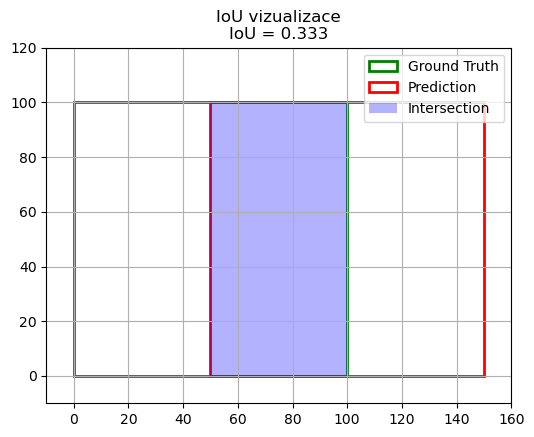

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def IoU(boxA, boxB):
    # box = (x1, y1, x2, y2)
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Výpočet průniku
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Výpočet ploch jednotlivých boxů
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Výpočet IoU
    iou = interArea / float(areaA + areaB - interArea)
    return iou, (xA, yA, xB, yB)

# 🧪 Testovací boxy
box_true = (0, 0, 100, 100)     # Ground truth
box_pred = (50, 0, 150, 100)    # Predikce – částečný překryv

# Výpočet a výpis IoU
iou, inter_box = IoU(box_true, box_pred)
print(f"IoU: {iou:.3f}")

# 🎨 Vizualizace
fig, ax = plt.subplots(1, figsize=(6, 6))

# Ground truth – zelený
rect_true = patches.Rectangle((box_true[0], box_true[1]),
                              box_true[2]-box_true[0],
                              box_true[3]-box_true[1],
                              linewidth=2, edgecolor='green', facecolor='none', label='Ground Truth')
ax.add_patch(rect_true)

# Predikce – červený
rect_pred = patches.Rectangle((box_pred[0], box_pred[1]),
                              box_pred[2]-box_pred[0],
                              box_pred[3]-box_pred[1],
                              linewidth=2, edgecolor='red', facecolor='none', label='Prediction')
ax.add_patch(rect_pred)

# Překryv – modrý (poloprůhledný)
inter_width = inter_box[2] - inter_box[0]
inter_height = inter_box[3] - inter_box[1]
if inter_width > 0 and inter_height > 0:
    rect_inter = patches.Rectangle((inter_box[0], inter_box[1]),
                                   inter_width, inter_height,
                                   linewidth=0, edgecolor='none', facecolor='blue', alpha=0.3, label='Intersection')
    ax.add_patch(rect_inter)

# Popisky
plt.title(f"IoU vizualizace\nIoU = {iou:.3f}")
plt.legend(loc='upper right')
plt.xlim(-10, 160)
plt.ylim(-10, 120)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()


# Skript pro výpočet AP50

1. Simuluje ground-truth a predikce pro jednu třídu ("car"),
2. Vypočítá metriky Precision a Recall při různých úrovních confidence (skóre),
3. Spočítá IoU (Intersection over Union) pro vyhodnocení přesnosti,
4. Nakonec vykreslí Precision-Recall křivku a vypíše AP50 (Average Precision při IoU ≥ 0.5).



AP50: 0.500


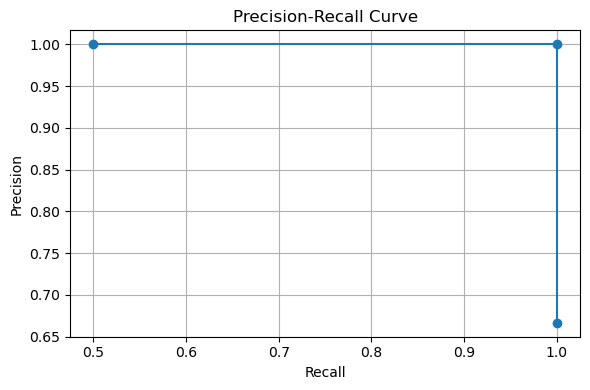

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ======= Pomocné třídy a funkce =======
class Box:
    def __init__(self, x1, y1, x2, y2, score=0.0, label="object"):
        self.box = (x1, y1, x2, y2)
        self.score = score
        self.label = label

def IoU(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(areaA + areaB - interArea)
    return iou

# ======= Ground-truth a predikce =======
ground_truth_objects = {
    "car": [
        Box(30, 30, 70, 70),
        Box(100, 100, 150, 150)
    ]
}

predictions = [
    Box(32, 32, 68, 68, score=0.95),    # správně
    Box(105, 105, 148, 148, score=0.85), # správně
    Box(200, 200, 250, 250, score=0.60)  # falešně
]

TARGET_CLASS = "car"
total_gt = len(ground_truth_objects[TARGET_CLASS])

# ======= Vyhodnocení detekcí =======
pred_class = sorted(predictions, key=lambda x: x.score, reverse=True)
tp = []
detected_gt = set()

for pred in pred_class:
    best_iou = 0
    best_gt = None
    for i, gt in enumerate(ground_truth_objects[TARGET_CLASS]):
        if i not in detected_gt:
            iou = IoU(pred.box, gt.box)
            if iou > best_iou:
                best_iou = iou
                best_gt = i
    if best_iou >= 0.5:
        tp.append(1)
        detected_gt.add(best_gt)
    else:
        tp.append(0)

# ======= Výpočet Precision-Recall =======
cum_TP = 0
precisions = []
recalls = []

for k in range(1, len(tp) + 1):
    cum_TP += tp[k - 1]
    precision_k = cum_TP / k
    recall_k = cum_TP / total_gt
    precisions.append(precision_k)
    recalls.append(recall_k)

# ======= Výpočet AP50 =======
AP50 = np.trapz(precisions, recalls)
print(f"AP50: {AP50:.3f}")

# ======= Graf Precision-Recall křivky =======
plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, marker='o')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# Pokračujme v pseudokódu z výše:
# Po přiřazení tp listu (1 pro TP, 0 pro FP při IoU=0.5)
precision_at_0_5 = sum(tp) / len(tp)
print(f"Precision@0.5: {precision_at_0_5:.3f}")

Precision@0.5: 0.667


# Vizualizace detekcí

Tento Python skript ilustruje výpočet metriky přesnosti (precision) a citlivosti (recall) pro detekci objektů pomocí hodnoty Intersection over Union (IoU), přičemž zároveň vizuálně zobrazí predikované a skutečné (ground truth) ohraničující rámečky:

1. Červené rámečky představují skutečné objekty (ground truth).
2. Zelené přerušované rámečky představují správné predikce (True Positives), které mají dostatečně velké překrytí s odpovídajícím ground truth objektem (IoU ≥ 0.5).
3. Modré přerušované rámečky představují nesprávné predikce (False Positives), které se nepřekrývají dostatečně.

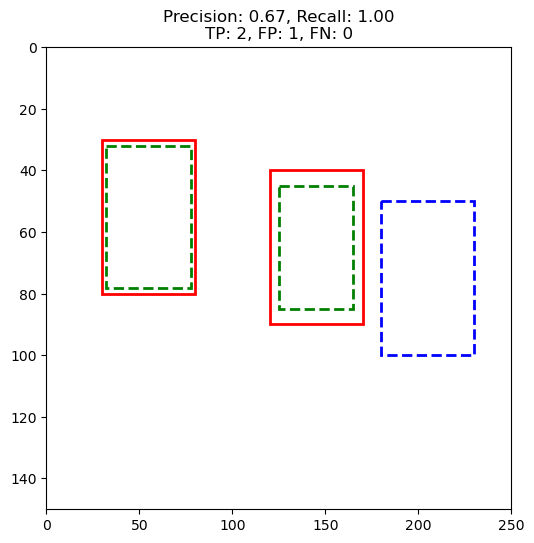

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Funkce pro výpočet IoU
def IoU(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(areaA + areaB - interArea)
    return iou

# Definice skutečných objektů a predikcí
ground_truth = [(30, 30, 80, 80), (120, 40, 170, 90)]  # GT boxy
predictions = [(32, 32, 78, 78), (125, 45, 165, 85), (180, 50, 230, 100)]  # predikce

# Inicializace počítadel
iou_threshold = 0.5
tp, fp, fn = 0, 0, 0
matched_gt = set()
results = []

# Vyhodnocení každé predikce
for pred in predictions:
    matched = False
    for i, gt in enumerate(ground_truth):
        if i in matched_gt:
            continue
        iou = IoU(pred, gt)
        if iou >= iou_threshold:
            tp += 1
            matched_gt.add(i)
            results.append((pred, 'tp'))
            matched = True
            break
    if not matched:
        fp += 1
        results.append((pred, 'fp'))

# Výpočet FN a metrik
fn = len(ground_truth) - tp
precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0

# Vykreslení
fig, ax = plt.subplots(1, figsize=(6, 6))
plt.xlim(0, 250)
plt.ylim(0, 150)
plt.gca().invert_yaxis()
ax.set_title(f'Precision: {precision:.2f}, Recall: {recall:.2f}\nTP: {tp}, FP: {fp}, FN: {fn}')

# Kreslení GT boxů – červeně
for gt in ground_truth:
    rect = patches.Rectangle((gt[0], gt[1]), gt[2]-gt[0], gt[3]-gt[1],
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

# Kreslení predikcí
for box, status in results:
    color = 'green' if status == 'tp' else 'blue'
    linestyle = '--'
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=2, edgecolor=color, linestyle=linestyle, facecolor='none')
    ax.add_patch(rect)

plt.show()
